In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import nltk
import transformers
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
from PIL import Image
import natsort
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import clip

import torch
from transformers import AutoTokenizer, DistilBertModel
import time
import random
import tensorflow as tf
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import mse
from keras import backend as K
from tensorflow.keras.layers import Dropout
TF_ENABLE_ONEDNN_OPTS=0

2023-06-16 23:53:57.664420: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## BASIC UTIL FUNCTION

In [3]:
def export_classification_report(report, mod, exec_time):
    lines = report.split('\n')
    data = lines[2:4] + lines[5:9]
    data = [line.split() for line in data]
    

    acc = float(data[2][1])
    m_prec = float(data[3][2])
    m_recall = float(data[3][3])
    m_f1 = float(data[3][4])
    w_prec = float(data[4][2])
    w_recall = float(data[4][3])
    w_f1 = float(data[4][4])
    
    df = pd.DataFrame({
        'Model': [mod],
        'Accuracy': [acc],
        'M-Precision': [m_prec],
        'M-Recall': [m_recall],
        'M-F1-Score': [m_f1],
        'W-Precision': [w_prec],
        'W-Recall': [w_recall],
        'W-F1-Score': [w_f1],
        'Runtime': [exec_time]
    })
    
    return df

## DATA PREPARATION

In [4]:
# Load the data


#  DistilBERT Embeddings (Text Only); (Train and Test Data Embeddings)

train2 = pd.read_csv('./training1.csv', delimiter='\t')

IDs = []  #set1
images = []
directory = 'TRAINING'   # directory where we have images 
filenames = natsort.natsorted(os.listdir(directory))  

# get the ids from the images, where images are having three channels; omit images if channels != 3
for i, filename in enumerate(filenames):
#     print(i, filename)
    if filename.endswith(".jpg"):
#         ID = int(filename[:-4])
        ID = filename
        pathname = os.path.join(directory, filename)
        im = Image.open(pathname)
        im = im.resize((224, 224))  # Resize the image to (224, 224)
        imnp = np.array(im)
        if len(imnp.shape) != 3:
#             print("This is 1 channel, so we omit it", imnp.shape, filename)
            continue
        IDs.append(ID)
        images.append(imnp)

def get_common_strings(list1, list2):
    return list(set(list1) & set(list2))

# Example usage
list1 = IDs
list2 = list(train2.file_name)  #from the text file where we have text description 
common_strings = get_common_strings(list1, list2)
print('len of common strings', len(common_strings))

sorted_ids = natsort.natsorted(common_strings)

# print(sorted_ids)

# Sort the dataframe with natural ordering of the IDs
train2['prefix_file_name'] = train2['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
sorted_train_df = train2.sort_values(by='prefix_file_name', ascending=True)
sorted_train_df

# Assuming 'df' is your DataFrame and 'common_strings' is the list of strings
# Get the common string values in the column 
filtered_df = sorted_train_df[sorted_train_df['file_name'].isin(sorted_ids)].reset_index(drop=True)

# Print the filtered DataFrame
print('filtered_df shape', filtered_df.shape)

train3 = filtered_df.copy()
# print(train3.shape)

trainx = train3.rename(columns={'Text Transcription': 'text'})
# display(trainx)



### LOAD TEST DATA

test1 = pd.read_csv('Test.csv', delimiter='\t')
test_labels = pd.read_csv('test_labels.txt', 
                          delimiter='\t',
                         header=None)

test_labels.columns = ['file_name', 
                      "misogynous",
                       "shaming",
                       "stereotype",
                       "objectification",
                       "violence"]

merged_test = pd.merge(test1, test_labels, on='file_name', how='inner')


# Sort the dataframe with natural ordering of the IDs
merged_test['prefix_file_name'] = merged_test['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
merged_test1 = merged_test.sort_values(by='prefix_file_name', ascending=True)
merged_test1


# # train = train.rename(columns={'Text Transcription': 'text'})
test2 = merged_test1.rename(columns={'Text Transcription': 'text'})
# test2



# ######################################################
train = trainx[['file_name', 'text', 'misogynous']]
train = train.rename(columns = {'misogynous':'label'})

test = test2[['file_name', 'text', 'misogynous']]
test = test.rename(columns = {'misogynous':'label'})

train['label'] = train['label'].map({0: 'non_misogyn', 1: 'misogyn'})
test['label'] = test['label'].map({0: 'non_misogyn', 1: 'misogyn'})
display(train)
display(test)

len of common strings 9986
filtered_df shape (9986, 8)


,file_name,text,label
0,1.jpg,Milk Milk.zip,non_misogyn
1,2.jpg,-What are you doing? -you told me to satanize ...,non_misogyn
2,3.jpg,imgflip.com ME 1254 NEW BUGS AFTER CHANGES BUG...,non_misogyn
3,4.jpg,Bedroom Kitchen Bathroom Bron memes storage,non_misogyn
4,5.jpg,WAKEUP EARLY FREELANCERS,non_misogyn
...,...,...,...
9981,15002.jpg,WAITING FOR THE END OF THE COVID imgflip.com,non_misogyn
9982,15003.jpg,SMART WOMEN ARE AROUND imgflip.com,non_misogyn
9983,15004.jpg,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,non_misogyn
9984,15005.jpg,COOKING FOR MY WIFE imgflip.com,non_misogyn


,file_name,text,label
436,15001.jpg,G HIS. UNDYING FIDELITY Steve is hot and perfe...,non_misogyn
854,15002.jpg,How limagined myself as a Teacher...... How I ...,non_misogyn
743,15004.jpg,WHERE WILL YOU BE WHEN DIARRHEA STRIKE memecen...,non_misogyn
44,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,non_misogyn
873,15006.jpg,THIS IS HOW YOUR GIRLFRIEND SEES YOUR FEMALE F...,non_misogyn
...,...,...,...
871,17078.jpg,There are multiple reasons to lower your car T...,non_misogyn
683,17079.jpg,MICHELLE OBAMA IS A MAN IGUARANTEE IT makeamem...,misogyn
406,17080.jpg,Looks like the airbags deployed 1234498,non_misogyn
733,17081.jpg,Half woman half horse,non_misogyn


## ALL THREE METHODS RUN FOR FEATURE EXTRACTION

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                        

2023-06-16 23:57:56.316959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 23:57:56.339262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 23:57:56.339391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 23:57:56.339738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10
109/313 [=========>....................] - ETA: 0s - loss: 94.7078 - kl_loss: 1.0606 - mse_loss: 93.6472  

2023-06-16 23:57:57.100439: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 1s 1ms/step - loss: 83.0534 - kl_loss: 0.6601 - mse_loss: 82.3933
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 74.5226 - kl_loss: 0.5415 - mse_loss: 73.9809
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 73.1577 - kl_loss: 0.6443 - mse_loss: 72.5134
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 72.2414 - kl_loss: 0.7318 - mse_loss: 71.5096
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 71.6102 - kl_loss: 0.8022 - mse_loss: 70.8080
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 71.2095 - kl_loss: 0.8409 - mse_loss: 70.3685
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 70.7001 - kl_loss: 0.8935 - mse_loss: 69.8066
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 70.3231 - kl_loss: 0.9216 - mse_loss: 69.4015
Epoch 9/10
313/313 [==============================]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)


/home/nitesh/env/dev38/python38/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-error:0.19417	validation_0-logloss:0.68451	validation_1-error:0.25476	validation_1-logloss:0.68593
[1]	validation_0-error:0.18590	validation_0-logloss:0.67621	validation_1-error:0.24975	validation_1-logloss:0.67900
[2]	validation_0-error:0.18703	validation_0-logloss:0.66822	validation_1-error:0.25025	validation_1-logloss:0.67229
[3]	validation_0-error:0.18378	validation_0-logloss:0.66049	validation_1-error:0.24625	validation_1-logloss:0.66587
[4]	validation_0-error:0.18453	validation_0-logloss:0.65307	validation_1-error:0.24324	validation_1-logloss:0.65964
[5]	validation_0-error:0.18440	validation_0-logloss:0.64577	validation_1-error:0.24575	validation_1-logloss:0.65362
[6]	validation_0-error:0.18165	validation_0-logloss:0.63878	validation_1-error:0.24274	validation_1-logloss:0.64797
[7]	validation_0-error:0.17739	validation_0-logloss:0.63198	validation_1-error:0.24174	validation_1-logloss:0.64241
[8]	validation_0-error:0.17426	validation_0-logloss:0.62544	validation_1

[71]	validation_0-error:0.12732	validation_0-logloss:0.40069	validation_1-error:0.21021	validation_1-logloss:0.47436
[72]	validation_0-error:0.12682	validation_0-logloss:0.39860	validation_1-error:0.21121	validation_1-logloss:0.47312
[73]	validation_0-error:0.12644	validation_0-logloss:0.39649	validation_1-error:0.21121	validation_1-logloss:0.47188
[74]	validation_0-error:0.12556	validation_0-logloss:0.39462	validation_1-error:0.21021	validation_1-logloss:0.47090
[75]	validation_0-error:0.12556	validation_0-logloss:0.39266	validation_1-error:0.21121	validation_1-logloss:0.46959
[76]	validation_0-error:0.12431	validation_0-logloss:0.39087	validation_1-error:0.21171	validation_1-logloss:0.46850
[77]	validation_0-error:0.12381	validation_0-logloss:0.38895	validation_1-error:0.20971	validation_1-logloss:0.46722
[78]	validation_0-error:0.12293	validation_0-logloss:0.38718	validation_1-error:0.21071	validation_1-logloss:0.46627
[79]	validation_0-error:0.12256	validation_0-logloss:0.38529	val

[141]	validation_0-error:0.08876	validation_0-logloss:0.30040	validation_1-error:0.20120	validation_1-logloss:0.42747
[142]	validation_0-error:0.08826	validation_0-logloss:0.29928	validation_1-error:0.20070	validation_1-logloss:0.42709
[143]	validation_0-error:0.08776	validation_0-logloss:0.29841	validation_1-error:0.20120	validation_1-logloss:0.42674
[144]	validation_0-error:0.08675	validation_0-logloss:0.29726	validation_1-error:0.20020	validation_1-logloss:0.42660
[145]	validation_0-error:0.08650	validation_0-logloss:0.29613	validation_1-error:0.20070	validation_1-logloss:0.42620
[146]	validation_0-error:0.08638	validation_0-logloss:0.29532	validation_1-error:0.20170	validation_1-logloss:0.42578
[147]	validation_0-error:0.08538	validation_0-logloss:0.29429	validation_1-error:0.20170	validation_1-logloss:0.42543
[148]	validation_0-error:0.08538	validation_0-logloss:0.29319	validation_1-error:0.20220	validation_1-logloss:0.42519
[149]	validation_0-error:0.08500	validation_0-logloss:0.

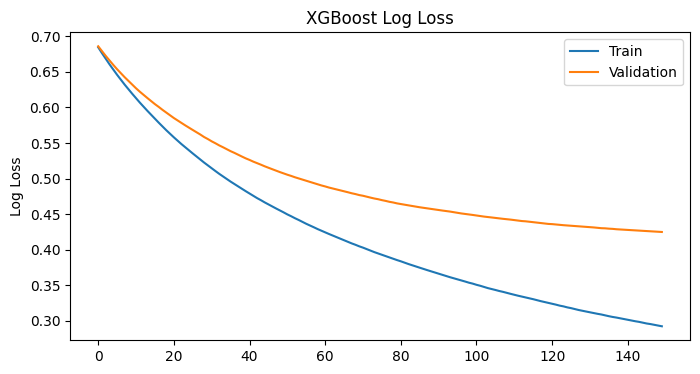

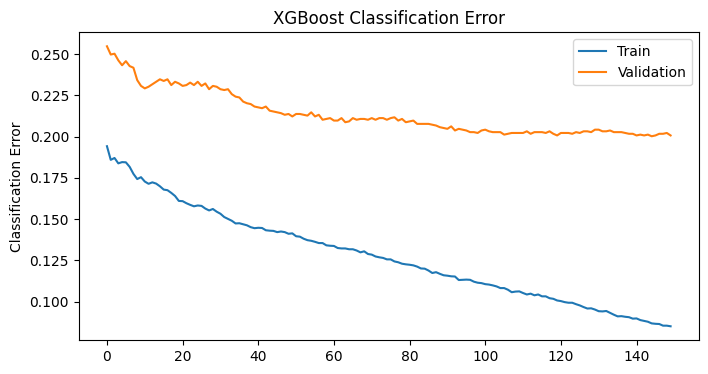

              precision    recall  f1-score   support

           0       0.86      0.48      0.62       500
           1       0.64      0.92      0.76       500

    accuracy                           0.70      1000
   macro avg       0.75      0.70      0.69      1000
weighted avg       0.75      0.70      0.69      1000

Execution time: 254.28715991973877 seconds


/tmp/ipykernel_12151/2674042376.py:528: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_5[0][0]']                
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19892	validation_0-logloss:0.68505	validation_1-error:0.25526	validation_1-logloss:0.68628
[1]	validation_0-error:0.19091	validation_0-logloss:0.67718	validation_1-error:0.24124	validation_1-logloss:0.67967
[2]	validation_0-error:0.19216	validation_0-logloss:0.66964	validation_1-error:0.24074	validation_1-logloss:0.67331
[3]	validation_0-error:0.19254	validation_0-logloss:0.66243	validation_1-error:0.24174	validation_1-logloss:0.66730
[4]	validation_0-error:0.18628	validation_0-logloss:0.65539	validation_1-error:0.23473	validation_1-logloss:0.66130
[5]	validation_0-error:0.18490	validation_0-logloss:0.64866	validation_1-error:0.23523	validation_1-logloss:0.65562
[6]	validation_0-error:0.18052	validation_0-logloss:0.64202	validation_1-error:0.23123	validation_1-logloss:0.65025
[7]	validation_0-error:0.17639	validation_0-logloss:0.63561	validation_1-error:0.23223	validation_1-logloss:0.64524
[

[70]	validation_0-error:0.12531	validation_0-logloss:0.41316	validation_1-error:0.19570	validation_1-logloss:0.48391
[71]	validation_0-error:0.12469	validation_0-logloss:0.41101	validation_1-error:0.19470	validation_1-logloss:0.48267
[72]	validation_0-error:0.12394	validation_0-logloss:0.40863	validation_1-error:0.19269	validation_1-logloss:0.48134
[73]	validation_0-error:0.12231	validation_0-logloss:0.40681	validation_1-error:0.19319	validation_1-logloss:0.48018
[74]	validation_0-error:0.12256	validation_0-logloss:0.40500	validation_1-error:0.19319	validation_1-logloss:0.47902
[75]	validation_0-error:0.12231	validation_0-logloss:0.40329	validation_1-error:0.19319	validation_1-logloss:0.47800
[76]	validation_0-error:0.12131	validation_0-logloss:0.40111	validation_1-error:0.19369	validation_1-logloss:0.47661
[77]	validation_0-error:0.12056	validation_0-logloss:0.39905	validation_1-error:0.19419	validation_1-logloss:0.47542
[78]	validation_0-error:0.12043	validation_0-logloss:0.39700	val

[140]	validation_0-error:0.08813	validation_0-logloss:0.30844	validation_1-error:0.18669	validation_1-logloss:0.42967
[141]	validation_0-error:0.08688	validation_0-logloss:0.30742	validation_1-error:0.18719	validation_1-logloss:0.42919
[142]	validation_0-error:0.08675	validation_0-logloss:0.30641	validation_1-error:0.18669	validation_1-logloss:0.42873
[143]	validation_0-error:0.08675	validation_0-logloss:0.30523	validation_1-error:0.18719	validation_1-logloss:0.42834
[144]	validation_0-error:0.08688	validation_0-logloss:0.30435	validation_1-error:0.18819	validation_1-logloss:0.42794
[145]	validation_0-error:0.08600	validation_0-logloss:0.30330	validation_1-error:0.18669	validation_1-logloss:0.42760
[146]	validation_0-error:0.08563	validation_0-logloss:0.30249	validation_1-error:0.18819	validation_1-logloss:0.42723
[147]	validation_0-error:0.08550	validation_0-logloss:0.30138	validation_1-error:0.18769	validation_1-logloss:0.42684
[148]	validation_0-error:0.08475	validation_0-logloss:0.

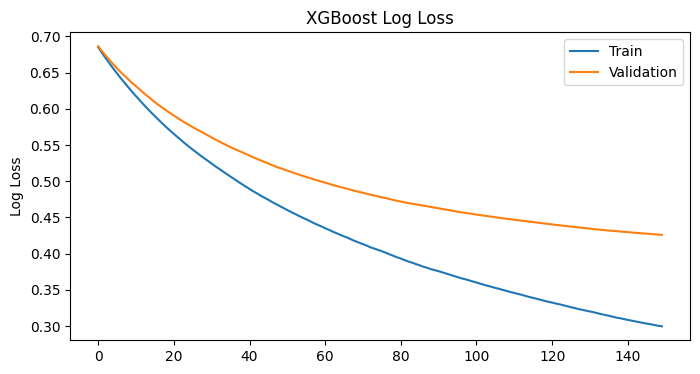

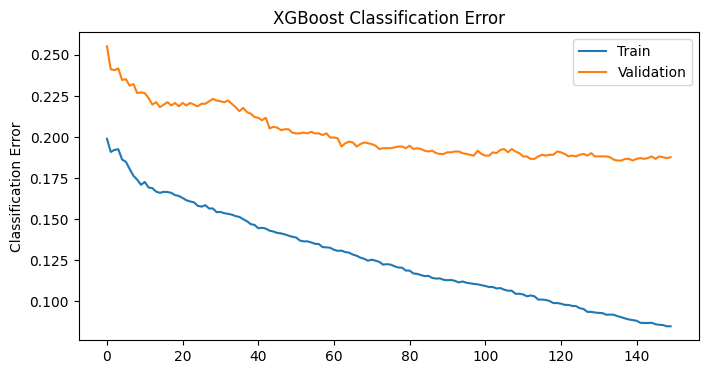

              precision    recall  f1-score   support

           0       0.85      0.52      0.65       500
           1       0.66      0.91      0.76       500

    accuracy                           0.72      1000
   macro avg       0.75      0.72      0.71      1000
weighted avg       0.75      0.72      0.71      1000

Execution time: 268.089426279068 seconds


/tmp/ipykernel_12151/2674042376.py:528: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_10[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.18140	validation_0-logloss:0.68419	validation_1-error:0.23824	validation_1-logloss:0.68549
[1]	validation_0-error:0.17989	validation_0-logloss:0.67556	validation_1-error:0.23373	validation_1-logloss:0.67801
[2]	validation_0-error:0.17389	validation_0-logloss:0.66715	validation_1-error:0.23574	validation_1-logloss:0.67093
[3]	validation_0-error:0.16800	validation_0-logloss:0.65907	validation_1-error:0.23373	validation_1-logloss:0.66438
[4]	validation_0-error:0.16087	validation_0-logloss:0.65124	validation_1-error:0.23073	validation_1-logloss:0.65798
[5]	validation_0-error:0.16312	validation_0-logloss:0.64368	validation_1-error:0.23523	validation_1-logloss:0.65186
[6]	validation_0-error:0.15899	validation_0-logloss:0.63636	validation_1-error:0.22923	validation_1-logloss:0.64595
[7]	validation_0-error:0.15749	validation_0-logloss:0.62929	validation_1-error:0.22923	validation_1-logloss:0.64024
[

[70]	validation_0-error:0.12056	validation_0-logloss:0.39891	validation_1-error:0.21572	validation_1-logloss:0.47391
[71]	validation_0-error:0.12043	validation_0-logloss:0.39668	validation_1-error:0.21271	validation_1-logloss:0.47274
[72]	validation_0-error:0.11943	validation_0-logloss:0.39475	validation_1-error:0.21421	validation_1-logloss:0.47161
[73]	validation_0-error:0.11955	validation_0-logloss:0.39269	validation_1-error:0.21271	validation_1-logloss:0.47057
[74]	validation_0-error:0.11930	validation_0-logloss:0.39095	validation_1-error:0.21271	validation_1-logloss:0.46957
[75]	validation_0-error:0.11830	validation_0-logloss:0.38890	validation_1-error:0.21071	validation_1-logloss:0.46852
[76]	validation_0-error:0.11793	validation_0-logloss:0.38708	validation_1-error:0.21221	validation_1-logloss:0.46742
[77]	validation_0-error:0.11718	validation_0-logloss:0.38506	validation_1-error:0.21271	validation_1-logloss:0.46632
[78]	validation_0-error:0.11680	validation_0-logloss:0.38327	val

[140]	validation_0-error:0.09289	validation_0-logloss:0.30074	validation_1-error:0.19419	validation_1-logloss:0.42616
[141]	validation_0-error:0.09264	validation_0-logloss:0.29964	validation_1-error:0.19419	validation_1-logloss:0.42577
[142]	validation_0-error:0.09189	validation_0-logloss:0.29880	validation_1-error:0.19620	validation_1-logloss:0.42551
[143]	validation_0-error:0.09151	validation_0-logloss:0.29781	validation_1-error:0.19470	validation_1-logloss:0.42519
[144]	validation_0-error:0.09114	validation_0-logloss:0.29672	validation_1-error:0.19620	validation_1-logloss:0.42475
[145]	validation_0-error:0.09051	validation_0-logloss:0.29604	validation_1-error:0.19570	validation_1-logloss:0.42444
[146]	validation_0-error:0.09026	validation_0-logloss:0.29501	validation_1-error:0.19670	validation_1-logloss:0.42413
[147]	validation_0-error:0.08989	validation_0-logloss:0.29402	validation_1-error:0.19670	validation_1-logloss:0.42370
[148]	validation_0-error:0.08938	validation_0-logloss:0.

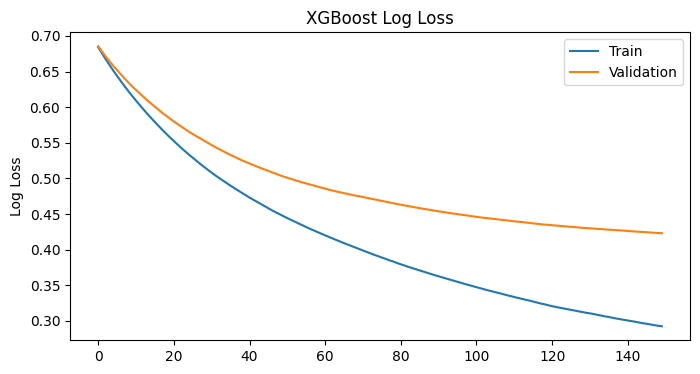

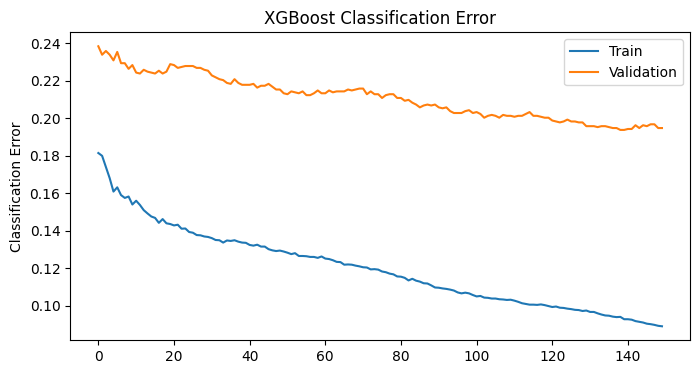

              precision    recall  f1-score   support

           0       0.88      0.52      0.66       500
           1       0.66      0.93      0.77       500

    accuracy                           0.73      1000
   macro avg       0.77      0.73      0.71      1000
weighted avg       0.77      0.73      0.71      1000

Execution time: 260.55837202072144 seconds


/tmp/ipykernel_12151/2674042376.py:528: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_15[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.20393	validation_0-logloss:0.68492	validation_1-error:0.26476	validation_1-logloss:0.68638
[1]	validation_0-error:0.19166	validation_0-logloss:0.67706	validation_1-error:0.25375	validation_1-logloss:0.67996
[2]	validation_0-error:0.17902	validation_0-logloss:0.66936	validation_1-error:0.24775	validation_1-logloss:0.67367
[3]	validation_0-error:0.18190	validation_0-logloss:0.66200	validation_1-error:0.23974	validation_1-logloss:0.66772
[4]	validation_0-error:0.17939	validation_0-logloss:0.65476	validation_1-error:0.23574	validation_1-logloss:0.66171
[5]	validation_0-error:0.17977	validation_0-logloss:0.64774	validation_1-error:0.23473	validation_1-logloss:0.65578
[6]	validation_0-error:0.17827	validation_0-logloss:0.64108	validation_1-error:0.22973	validation_1-logloss:0.65042
[7]	validation_0-error:0.17564	validation_0-logloss:0.63446	validation_1-error:0.22473	validation_1-logloss:0.64497
[

[70]	validation_0-error:0.11818	validation_0-logloss:0.40754	validation_1-error:0.20470	validation_1-logloss:0.48314
[71]	validation_0-error:0.11855	validation_0-logloss:0.40563	validation_1-error:0.20420	validation_1-logloss:0.48205
[72]	validation_0-error:0.11743	validation_0-logloss:0.40374	validation_1-error:0.20470	validation_1-logloss:0.48086
[73]	validation_0-error:0.11793	validation_0-logloss:0.40197	validation_1-error:0.20470	validation_1-logloss:0.47992
[74]	validation_0-error:0.11755	validation_0-logloss:0.39979	validation_1-error:0.20320	validation_1-logloss:0.47861
[75]	validation_0-error:0.11755	validation_0-logloss:0.39806	validation_1-error:0.20270	validation_1-logloss:0.47754
[76]	validation_0-error:0.11592	validation_0-logloss:0.39639	validation_1-error:0.20320	validation_1-logloss:0.47666
[77]	validation_0-error:0.11517	validation_0-logloss:0.39432	validation_1-error:0.20220	validation_1-logloss:0.47533
[78]	validation_0-error:0.11480	validation_0-logloss:0.39255	val

[140]	validation_0-error:0.08801	validation_0-logloss:0.30897	validation_1-error:0.19219	validation_1-logloss:0.43050
[141]	validation_0-error:0.08763	validation_0-logloss:0.30811	validation_1-error:0.19319	validation_1-logloss:0.43010
[142]	validation_0-error:0.08763	validation_0-logloss:0.30707	validation_1-error:0.19169	validation_1-logloss:0.42957
[143]	validation_0-error:0.08650	validation_0-logloss:0.30584	validation_1-error:0.19169	validation_1-logloss:0.42904
[144]	validation_0-error:0.08588	validation_0-logloss:0.30500	validation_1-error:0.19269	validation_1-logloss:0.42861
[145]	validation_0-error:0.08563	validation_0-logloss:0.30395	validation_1-error:0.19119	validation_1-logloss:0.42815
[146]	validation_0-error:0.08538	validation_0-logloss:0.30297	validation_1-error:0.19169	validation_1-logloss:0.42784
[147]	validation_0-error:0.08525	validation_0-logloss:0.30215	validation_1-error:0.19169	validation_1-logloss:0.42749
[148]	validation_0-error:0.08463	validation_0-logloss:0.

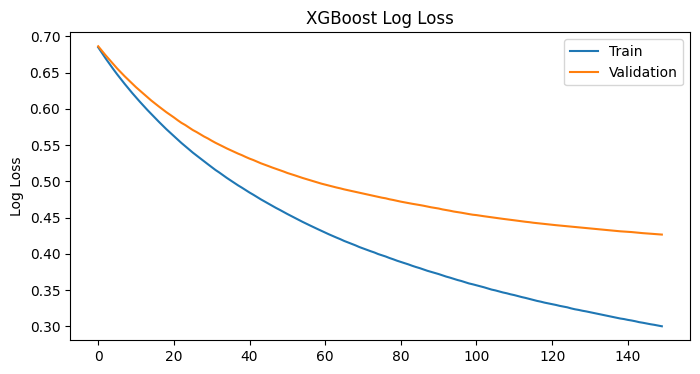

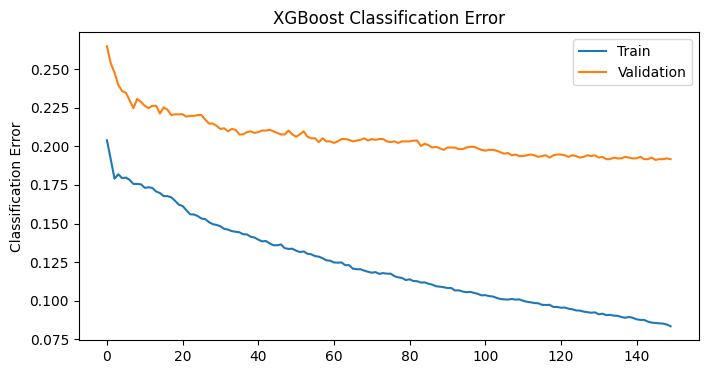

              precision    recall  f1-score   support

           0       0.88      0.47      0.62       500
           1       0.64      0.93      0.76       500

    accuracy                           0.70      1000
   macro avg       0.76      0.70      0.69      1000
weighted avg       0.76      0.70      0.69      1000

Execution time: 271.8067133426666 seconds


/tmp/ipykernel_12151/2674042376.py:528: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 128)          0           ['dense_20[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.20268	validation_0-logloss:0.68489	validation_1-error:0.24975	validation_1-logloss:0.68612
[1]	validation_0-error:0.18903	validation_0-logloss:0.67693	validation_1-error:0.25225	validation_1-logloss:0.67957
[2]	validation_0-error:0.18803	validation_0-logloss:0.66925	validation_1-error:0.25175	validation_1-logloss:0.67324
[3]	validation_0-error:0.18102	validation_0-logloss:0.66160	validation_1-error:0.25576	validation_1-logloss:0.66713
[4]	validation_0-error:0.18040	validation_0-logloss:0.65434	validation_1-error:0.25075	validation_1-logloss:0.66118
[5]	validation_0-error:0.17739	validation_0-logloss:0.64727	validation_1-error:0.24775	validation_1-logloss:0.65534
[6]	validation_0-error:0.17614	validation_0-logloss:0.64052	validation_1-error:0.24474	validation_1-logloss:0.64971
[7]	validation_0-error:0.17238	validation_0-logloss:0.63378	validation_1-error:0.24825	validation_1-logloss:0.64467
[

[70]	validation_0-error:0.11279	validation_0-logloss:0.40494	validation_1-error:0.21171	validation_1-logloss:0.48202
[71]	validation_0-error:0.11217	validation_0-logloss:0.40302	validation_1-error:0.21121	validation_1-logloss:0.48077
[72]	validation_0-error:0.11229	validation_0-logloss:0.40106	validation_1-error:0.20971	validation_1-logloss:0.47964
[73]	validation_0-error:0.11229	validation_0-logloss:0.39897	validation_1-error:0.20871	validation_1-logloss:0.47831
[74]	validation_0-error:0.11117	validation_0-logloss:0.39715	validation_1-error:0.20921	validation_1-logloss:0.47713
[75]	validation_0-error:0.11067	validation_0-logloss:0.39510	validation_1-error:0.20771	validation_1-logloss:0.47585
[76]	validation_0-error:0.11004	validation_0-logloss:0.39305	validation_1-error:0.20671	validation_1-logloss:0.47464
[77]	validation_0-error:0.11004	validation_0-logloss:0.39117	validation_1-error:0.20621	validation_1-logloss:0.47345
[78]	validation_0-error:0.10904	validation_0-logloss:0.38921	val

[140]	validation_0-error:0.08237	validation_0-logloss:0.30319	validation_1-error:0.19920	validation_1-logloss:0.42912
[141]	validation_0-error:0.08237	validation_0-logloss:0.30229	validation_1-error:0.19920	validation_1-logloss:0.42860
[142]	validation_0-error:0.08200	validation_0-logloss:0.30118	validation_1-error:0.19870	validation_1-logloss:0.42797
[143]	validation_0-error:0.08150	validation_0-logloss:0.30035	validation_1-error:0.19820	validation_1-logloss:0.42748
[144]	validation_0-error:0.08112	validation_0-logloss:0.29946	validation_1-error:0.20020	validation_1-logloss:0.42720
[145]	validation_0-error:0.08125	validation_0-logloss:0.29847	validation_1-error:0.20020	validation_1-logloss:0.42681
[146]	validation_0-error:0.08075	validation_0-logloss:0.29757	validation_1-error:0.20020	validation_1-logloss:0.42644
[147]	validation_0-error:0.08024	validation_0-logloss:0.29656	validation_1-error:0.19970	validation_1-logloss:0.42613
[148]	validation_0-error:0.07999	validation_0-logloss:0.

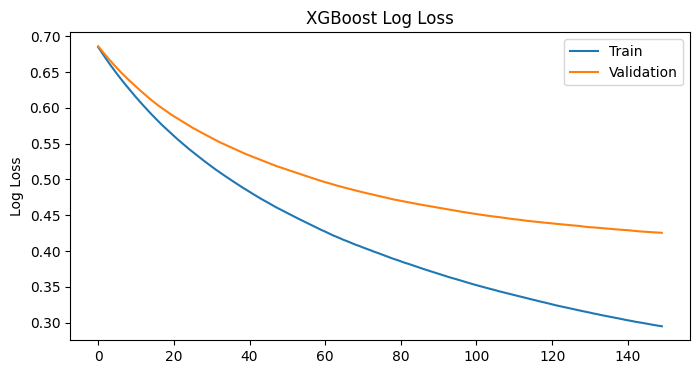

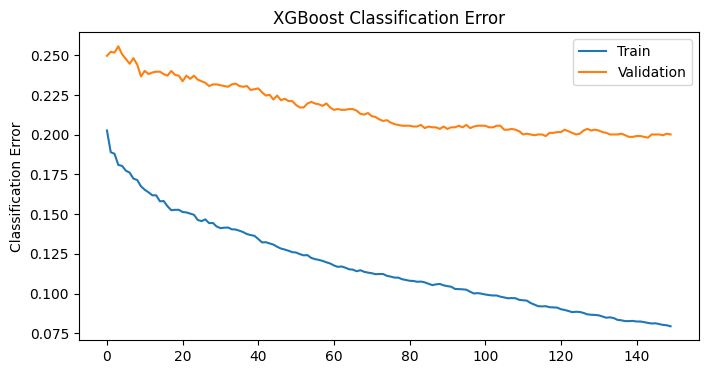

/tmp/ipykernel_12151/2674042376.py:528: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.87      0.51      0.64       500
           1       0.65      0.92      0.76       500

    accuracy                           0.71      1000
   macro avg       0.76      0.71      0.70      1000
weighted avg       0.76      0.71      0.70      1000

Execution time: 271.3600640296936 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_10 (Dropout)           (None, 128)          0           ['dense_25[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.18428	validation_0-logloss:0.68409	validation_1-error:0.24474	validation_1-logloss:0.68540
[1]	validation_0-error:0.18378	validation_0-logloss:0.67539	validation_1-error:0.24424	validation_1-logloss:0.67800
[2]	validation_0-error:0.17877	validation_0-logloss:0.66705	validation_1-error:0.24575	validation_1-logloss:0.67098
[3]	validation_0-error:0.17526	validation_0-logloss:0.65888	validation_1-error:0.23824	validation_1-logloss:0.66425
[4]	validation_0-error:0.17626	validation_0-logloss:0.65102	validation_1-error:0.23523	validation_1-logloss:0.65740
[5]	validation_0-error:0.16925	validation_0-logloss:0.64308	validation_1-error:0.22873	validation_1-logloss:0.65075
[6]	validation_0-error:0.16675	validation_0-logloss:0.63549	validation_1-error:0.22723	validation_1-logloss:0.64463
[7]	validation_0-error:0.16437	validation_0-logloss:0.62816	validation_1-error:0.22473	validation_1-logloss:0.63836
[

[70]	validation_0-error:0.12794	validation_0-logloss:0.39276	validation_1-error:0.20771	validation_1-logloss:0.46700
[71]	validation_0-error:0.12769	validation_0-logloss:0.39077	validation_1-error:0.20821	validation_1-logloss:0.46592
[72]	validation_0-error:0.12744	validation_0-logloss:0.38877	validation_1-error:0.20921	validation_1-logloss:0.46482
[73]	validation_0-error:0.12657	validation_0-logloss:0.38673	validation_1-error:0.20671	validation_1-logloss:0.46361
[74]	validation_0-error:0.12544	validation_0-logloss:0.38487	validation_1-error:0.20671	validation_1-logloss:0.46251
[75]	validation_0-error:0.12556	validation_0-logloss:0.38300	validation_1-error:0.20771	validation_1-logloss:0.46153
[76]	validation_0-error:0.12519	validation_0-logloss:0.38100	validation_1-error:0.20821	validation_1-logloss:0.46044
[77]	validation_0-error:0.12519	validation_0-logloss:0.37927	validation_1-error:0.20871	validation_1-logloss:0.45973
[78]	validation_0-error:0.12469	validation_0-logloss:0.37757	val

[140]	validation_0-error:0.09577	validation_0-logloss:0.29563	validation_1-error:0.19770	validation_1-logloss:0.42292
[141]	validation_0-error:0.09464	validation_0-logloss:0.29462	validation_1-error:0.19670	validation_1-logloss:0.42251
[142]	validation_0-error:0.09427	validation_0-logloss:0.29358	validation_1-error:0.19670	validation_1-logloss:0.42212
[143]	validation_0-error:0.09352	validation_0-logloss:0.29268	validation_1-error:0.19670	validation_1-logloss:0.42191
[144]	validation_0-error:0.09302	validation_0-logloss:0.29173	validation_1-error:0.19620	validation_1-logloss:0.42151
[145]	validation_0-error:0.09226	validation_0-logloss:0.29071	validation_1-error:0.19470	validation_1-logloss:0.42118
[146]	validation_0-error:0.09164	validation_0-logloss:0.28989	validation_1-error:0.19520	validation_1-logloss:0.42086
[147]	validation_0-error:0.09139	validation_0-logloss:0.28899	validation_1-error:0.19520	validation_1-logloss:0.42050
[148]	validation_0-error:0.09064	validation_0-logloss:0.

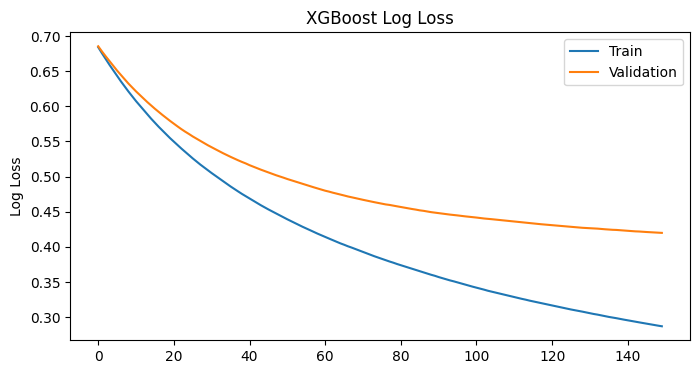

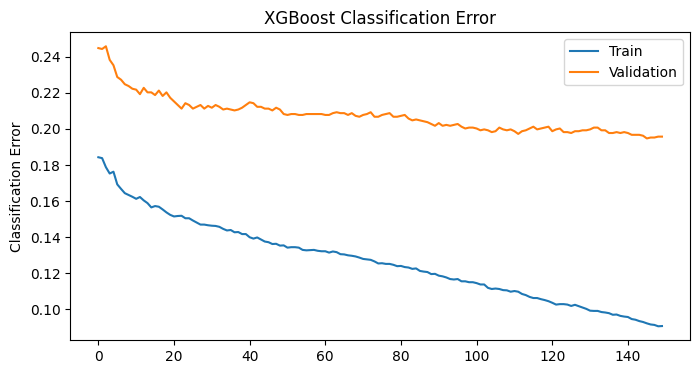

              precision    recall  f1-score   support

           0       0.87      0.49      0.62       500
           1       0.64      0.93      0.76       500

    accuracy                           0.71      1000
   macro avg       0.76      0.71      0.69      1000
weighted avg       0.76      0.71      0.69      1000

Execution time: 302.70825386047363 seconds


/tmp/ipykernel_12151/2674042376.py:528: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


In [5]:
### TRAINING

df_BLPCLPXGB = pd.DataFrame(columns=['Model', 'Accuracy', 
                       'M-Precision', 'M-Recall', 
                       'M-F1-Score', 'W-Precision',
                       'W-Recall', 'W-F1-Score', 'Runtime'])


mse_val1 = []
KL_LOSS1 = []

# Store results in DataFrame
xgboost_clsfn_errrep  = pd.DataFrame(columns=["Bootstrap_Sample_Seed", "Train_LogLoss",
                                              "Validation_LogLoss", "Train_Error",
                                              "Validation_Error"])



for KK in list([7,10,18,22,55,77]):
    
    start_time = time.time()

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)


    device = "cpu"

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    model.to(device)
    projection_layer = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer.to(device)

    train_encodings = tokenizer(
        train["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings = tokenizer(
        test["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )


    with torch.no_grad():
        train_outputs = model(**train_encodings.to(device))
        train_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings = projection_layer(train_embeddings)  # Project embeddings to size 65

        test_outputs = model(**test_encodings.to(device))
        test_embeddings = test_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings = projection_layer(test_embeddings)  # Project embeddings to size 65

    train_embeddings = train_embeddings.cpu().numpy()
    test_embeddings = test_embeddings.cpu().numpy()

    print("train embeddings shape:", train_embeddings.shape)
    print("test embeddings shape:", test_embeddings.shape)





    # CLIP Image Embeddings (Training Image Embeddings)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    #  watch -n 2 nvidia-smi


    # model_16

    # Define the directory containing the images
    IDs = []  #set1
    images = []
    image_dir = "./TRAINING"
    # # Load the data
    train2 = pd.read_csv('./training1.csv', delimiter='\t')

    # Get a list of image filenames in the directory
    filenames = natsort.natsorted(os.listdir(image_dir))
    # len(image_filenames)

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(filenames):
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            ID = filename
            pathname = os.path.join(image_dir, filename)
            im = Image.open(pathname)
    #         print(im.size)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            imnp = np.array(im)
            if len(imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue
            IDs.append(ID)
            images.append(imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    list1 = IDs
    list2 = list(train2.file_name)  #from the text file where we have text description 
    common_strings = get_common_strings(list1, list2)
    print('len of common strings', len(common_strings))

    image_filenames = natsort.natsorted(common_strings)
    # display(image_filenames)

    import pandas as pd

    train_labelset = train2[['file_name', 'misogynous']]
    IDs_df = pd.DataFrame({'file_name': image_filenames})
    joined_df = IDs_df.merge(train_labelset, on='file_name', how='left')
    misogynous_labels = joined_df['misogynous'].tolist()


    #######################################################################


    # Create an empty list to store the image features
    all_image_features_16 = []


    model_16, preprocess_16 = clip.load('ViT-B/16', device=device)

    # Process each image and extract features
    for filename in image_filenames:
        image_path = os.path.join(image_dir, filename)

        # Preprocess the image
        image_16 = preprocess_16(Image.open(image_path)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features_16 = model_16.encode_image(image_16)

        # Append the image features to the list
        all_image_features_16.append(image_features_16)

    # Concatenate the image features into a single tensor
    all_image_features_16 = torch.cat(all_image_features_16, dim=0)
    print(all_image_features_16.shape)
    # torch.Size([9986, 512])



    ## REDUCE 512 EMBEDDING SIZE TO 64 EMBEDDING SIZE #####
    #######################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    embedding_size = 64
    all_image_features_16_cpu = all_image_features_16.cpu()
    all_image_features_16_numpy = all_image_features_16_cpu.numpy()



    ## using the below Sampling class from WK08 lab tutorials. 
    class Sampling(layers.Layer):


        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
            Sampling from the distribution of z_mu and z_var helps in 
            generating new point in latent space which we can pass to the decoder network 
            to reconstruct the data samples similar to original input
        """
        def call(self, inputs):

            #the encoder network produces a mean and a variance for each dimension of the latent space.
            z_mean, z_log_var = inputs

            # epsilon is not a weight (ie is not learned) and is not calculated based on 
            # the output of the previous layer.
            # epsilon is just a constant Tensor (a new one, each time we call this layer).


            epsilon = K.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)


    # for the encoder part, now the original dimension would be the pretrained model output flattened features
    # dimension
    original_dim = all_image_features_16_numpy.shape[1] 
    intermediate_dim = 128  
    intermediate_dim_1 = 64

    latent_dim = embedding_size  # i.e. 18, we set latent dimension to be of embedding size i.e. 18.

    # Define Input to the encoder 
    #Encoder Model Structure
    original_inputs = layers.Input(shape=(original_dim,), name="encoder_input")
    x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim_1, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))   #updated
    encoder = models.Model(inputs=original_inputs, outputs=z, name="encoder") 
    # encoder = models.Model(inputs=original_inputs, outputs=[z_mean, z_log_var], name="encoder")


    #decoder model
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(intermediate_dim_1, activation="relu")(latent_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim, activation="relu")(x)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)
    decoder = models.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

    # z = Sampling()((z_mean, z_log_var))
    outputs = decoder(z)
    vae = models.Model(inputs=original_inputs, outputs=outputs, name="vae")
    vae.summary()

    #get the reconstruction loss
    reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
    reconstruction_loss = original_dim * K.mean(reconstruction_loss)

    # regularization KL divergence term encourages the learned latent space to be a smooth manifold.
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(kl_loss)
    vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    vae.add_loss(reconstruction_loss)
    vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    # set Adam optimizer with learning ate 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    #Compile the model 
    vae.compile(optimizer)

    # Train. x_train is both the "x" and the "y"
    # vae.fit(flat_features, flat_features, epochs=10)

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    vaemod = vae.fit(all_image_features_16_numpy, all_image_features_16_numpy, epochs=10)
    # Increasing the epochs performing badly when we run k-neareast neighbour to achieve the 
    # nearest posters. 

    #In this code, we first need to build the vae model before using encoder.predict(). 
    #This is because the encoder model is a part of the vae model and needs to be built first.

    ## KL LOSS

    KL_LOSS =  vaemod.history['kl_loss']

    KL_LOSS1.append(KL_LOSS)

    mse_val =  vaemod.history['mse_loss']
    print(mse_val)

    mse_val1.append(mse_val)


    latent_emb = encoder.predict(all_image_features_16_numpy)  
    # z_mean, z_log_var = encoder.predict(all_image_features_16_numpy)
    # latent_emb = Sampling()((z_mean, z_log_var))
    print(latent_emb.shape) 

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')





    # CLIP Image Embeddings (Test Image Embeddings)

    # TEST DATA IMAGES LOADING


    TEST_IDs = []  #set1
    TEST_images = []
    TEST_directory = './TEST'   # directory where we have images 
    test_filenames = natsort.natsorted(os.listdir(TEST_directory))  

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(test_filenames):
    #     print(i, filename)
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            TEST_ID = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_imnp = np.array(im)
            if len(TEST_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_imnp.shape, filename)
                continue
            TEST_IDs.append(TEST_ID)
            TEST_images.append(TEST_imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    TEST_list1 = TEST_IDs
    TEST_list2 = list(test2.file_name)  #from the text file where we have text description 
    TEST_common_strings = get_common_strings(TEST_list1, TEST_list2)
    print('len of common strings', len(TEST_common_strings))

    TEST_sorted_ids = natsort.natsorted(TEST_common_strings)
    # len(TEST_sorted_ids)


    TEST_IDs1 = []
    TEST_images1 = [] 
    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(TEST_sorted_ids):
    #     print(i, filename)
        if filename.endswith(".jpg"):
            TEST_ID_0 = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_1_imnp = np.array(im)
            if len(TEST_1_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_1_imnp.shape, filename)
                continue
    #         print('Filename', TEST_ID_0)
            TEST_IDs1.append(TEST_ID_0)
            TEST_images1.append(TEST_1_imnp)


    len(TEST_images1), len(TEST_IDs1)


    #### TEST EMBEDDINGS #####
    clip_test_embeddings = []

    for image in TEST_images1:
        # Preprocess the image
        image_tensor = preprocess_16(Image.fromarray(image)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features = model_16.encode_image(image_tensor)

        # Append the image features to the list
        clip_test_embeddings.append(image_features)

    clip_test_embeddings = torch.cat(clip_test_embeddings, dim=0)

    # Move the test embeddings tensor to the CPU
    clip_test_embeddings = clip_test_embeddings.cpu()

    # Convert the test embeddings tensor to a NumPy array
    clip_test_embeddings_np = clip_test_embeddings.numpy()

    # Use the existing encoder to reduce the dimensions of the test embeddings
    reduced_test_embeddings  = encoder.predict(clip_test_embeddings_np)
    # z_mean_clipmod, z_log_var_clipmod = encoder.predict(clip_test_embeddings_np)
    # reduced_test_embeddings = Sampling()((z_mean_clipmod, z_log_var_clipmod))

    print('Image Test Embeddings Dimension', reduced_test_embeddings.shape)



    if os.getcwd() != "/home/nitesh/Documents/MY_THESIS/MAMI/BLIP":
        %cd BLIP
    print(os.getcwd())

    # Load the training captions data and test captions data files. 
    train_capn = pd.read_csv('train_BLIP_captions.csv')

    test_capn = pd.read_csv('test_BLIP_captions.csv')



    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP

    from transformers import DistilBertTokenizer, DistilBertModel
    tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model1 = DistilBertModel.from_pretrained("distilbert-base-uncased")


    device = "cpu"
    model1.to(device)
    projection_layer1 = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer1.to(device)

    train_encodings1 = tokenizer1(
        train_capn["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings1 = tokenizer1(
        test_capn["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        train_outputs1 = model1(**train_encodings1.to(device))
        train_embeddings1 = train_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings1 = projection_layer1(train_embeddings1)  # Project embeddings to size 65

        test_outputs1 = model1(**test_encodings1.to(device))
        test_embeddings1 = test_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings1 = projection_layer1(test_embeddings1)  # Project embeddings to size 65


    # Concatenate the text and image embeddings
    fusion_embeddings_train = np.concatenate((train_embeddings, latent_emb, train_embeddings1), axis=1)
    print('Fusion Embeddings Train', fusion_embeddings_train.shape)


    # Concatenate the text and image embeddings
    fusion_embeddings_test = np.concatenate((test_embeddings, reduced_test_embeddings, test_embeddings1), axis=1)
    print('Fusion Embeddings Test', fusion_embeddings_test.shape)


    import pickle
    # Save the embeddings as a pickle object
    pickle_path_train = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/fusion_embeddings_train_{KK}.pkl"
    with open(pickle_path_train, 'wb') as f:
        pickle.dump(fusion_embeddings_train, f)

    # Save the embeddings as a pickle object
    pickle_path_test = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/fusion_embeddings_test_{KK}.pkl"
    with open(pickle_path_test, 'wb') as f:
        pickle.dump(fusion_embeddings_test, f)


    from sklearn.model_selection import train_test_split
    import xgboost as xgb 
    train_lbls = train.label.map({'non_misogyn': 0, 'misogyn': 1})

    X_train, X_test, y_train, y_test = train_test_split(fusion_embeddings_train, train_lbls, 
                                                        test_size=0.20, random_state=7)

    # Initialize the XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(n_estimators=150, learning_rate=0.02)

    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_classifier.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

    from matplotlib import pyplot
    import matplotlib.pyplot as plt

    results = xgb_classifier.evals_result()
    epochs = len(results["validation_0"]["error"])
    x_axis = range(0, epochs)


    # plot log loss
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
    ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
    ax.legend()
    pyplot.ylabel("Log Loss")
    pyplot.title("XGBoost Log Loss")
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["error"], label="Train")
    ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
    ax.legend()
    pyplot.ylabel("Classification Error")
    pyplot.title("XGBoost Classification Error")
    pyplot.show()


    row_data = {
        "Bootstrap_Sample_Seed": KK,
        "Train_LogLoss": results["validation_0"]["logloss"],
        "Validation_LogLoss": results["validation_1"]["logloss"],
        "Train_Error": results["validation_0"]["error"],
        "Validation_Error": results["validation_1"]["error"]
    }
    xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


    # Make predictions on the test set
    from sklearn.metrics import classification_report 

    y_pred = xgb_classifier.predict(fusion_embeddings_test)
    # test_lbls = test.label

    test_lbls = test.label.map({'non_misogyn': 0, 'misogyn': 1})
    print(classification_report(test_lbls, y_pred))
    #     print(classification_report(test["label"].tolist(), y_pred))

    report_clip_blip_xgboost = classification_report(test_lbls, y_pred, digits=3)
    #     report_clip_blip_xgboost = classification_report(test["label"].tolist(), y_pred, digits=3)
    #     print(classification_report(test["label"].tolist(), y_pred))


    end_time = time.time()
    execution_time1 = end_time - start_time

    print(f"Execution time: {execution_time1} seconds")

    modname = 'DistilBERT_ViT_VAE_BLIP_XGBOOST'
    df1 = export_classification_report(report_clip_blip_xgboost, modname, execution_time1)
    df_BLPCLPXGB = pd.concat([df_BLPCLPXGB, df1])
    
    os.chdir("/home/nitesh/Documents/MY_THESIS/MAMI")

    del start_time, tokenizer, model, projection_layer
    del train_encodings, test_encodings, train_outputs, test_outputs
    del train_embeddings, test_embeddings
    del IDs, images, image_dir, train2, filenames, common_strings, image_filenames
    del train_labelset, IDs_df, joined_df, misogynous_labels
    del all_image_features_16, model_16, preprocess_16
    del all_image_features_16_cpu, all_image_features_16_numpy
    del Sampling, original_dim, intermediate_dim, intermediate_dim_1, latent_dim
    del original_inputs, x, z_mean, z_log_var, z, encoder
    del latent_inputs, outputs, decoder, vae, optimizer, reconstruction_loss, kl_loss
    del latent_emb, TEST_IDs, TEST_images, TEST_directory, test_filenames, TEST_common_strings
    del TEST_sorted_ids, TEST_IDs1, TEST_images1, clip_test_embeddings, clip_test_embeddings_np
    del reduced_test_embeddings, train_capn, test_capn

    # display(xgboost_clsfn_errrep)




A bootstrap sample is a random sample taken with replacement from a dataset. It is a common resampling technique used in statistics and machine learning.

When creating a bootstrap sample, you randomly select observations from the original dataset, allowing for duplicate selections (sampling with replacement). The size of the bootstrap sample is usually the same as the size of the original dataset, although it can be smaller or larger depending on the specific use case.

The purpose of bootstrap sampling is to estimate the sampling distribution or variability of a statistic calculated on the original dataset. By generating multiple bootstrap samples and calculating the statistic of interest for each sample, you can obtain an empirical estimate of the sampling distribution. This information can be useful for constructing confidence intervals, assessing the stability of statistical estimates, and performing hypothesis testing.

Bootstrap sampling allows you to obtain insights into the variability and uncertainty associated with a dataset and its statistical estimates without making strict assumptions about the underlying population distribution.

In [6]:
xgboost_clsfn_errrep

,Bootstrap_Sample_Seed,Train_LogLoss,Validation_LogLoss,Train_Error,Validation_Error
0,7,"[0.684509, 0.676207, 0.668222, 0.660491, 0.653...","[0.68593, 0.679005, 0.672291, 0.665869, 0.6596...","[0.194166, 0.185904, 0.187031, 0.183776, 0.184...","[0.254755, 0.24975, 0.25025, 0.246246, 0.24324..."
1,10,"[0.685047, 0.677177, 0.669641, 0.662427, 0.655...","[0.686284, 0.67967, 0.67331, 0.667302, 0.66129...","[0.198923, 0.190911, 0.192163, 0.192539, 0.186...","[0.255255, 0.241241, 0.240741, 0.241742, 0.234..."
2,18,"[0.684185, 0.67556, 0.667151, 0.659072, 0.6512...","[0.685493, 0.678008, 0.670931, 0.664375, 0.657...","[0.181397, 0.179895, 0.173886, 0.168002, 0.160...","[0.238238, 0.233734, 0.235736, 0.233734, 0.230..."
3,22,"[0.684922, 0.67706, 0.669359, 0.662001, 0.6547...","[0.68638, 0.679959, 0.673673, 0.667722, 0.6617...","[0.203931, 0.191662, 0.179019, 0.181898, 0.179...","[0.264765, 0.253754, 0.247748, 0.23974, 0.2357..."
4,55,"[0.684889, 0.676934, 0.669246, 0.661595, 0.654...","[0.686122, 0.679568, 0.673235, 0.667129, 0.661...","[0.202679, 0.189034, 0.188032, 0.181022, 0.180...","[0.24975, 0.252252, 0.251752, 0.255756, 0.2507..."
5,77,"[0.684091, 0.675391, 0.667051, 0.658876, 0.651...","[0.685397, 0.678, 0.670981, 0.664246, 0.657397...","[0.184276, 0.183776, 0.178768, 0.175263, 0.176...","[0.244745, 0.244244, 0.245746, 0.238238, 0.235..."


In [7]:
# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/xgboost_clsfn_errrep.csv'

xgboost_clsfn_errrep.to_csv(csv_file, index=False)


In [14]:
# df_BLPCLPXGB
# mse_val1[0]

1. how to change the epochs in xgb? 
2. how to get the error log results in a table or csv?

## VAE TRAINING LOSS VS EPOCH PLOT [SAVE PLOT]

In [16]:
num_lists = len(mse_val1)  # Number of lists
epochs = range(1, 11)  # Epochs (assuming 10 epochs)

# AX=[7,10,18,22,55,77]
# Plot each list in mse_val1
for i,j in zip(range(num_lists), list([7,10,18,22,55,77])):         
    plt.plot(epochs, mse_val1[i], label=f'MSE Loss vs Epochs Sample={j}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Value')
    plt.title('MSE Value vs. Epochs for')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'VAE_TrainingLoss_Epoch_Plot_{j}.png')


    plt.legend()
    plt.close()  # Close the connection 

# # Save the plots in the local directory
# for i in range(num_lists):
#     plt.savefig(f'plot_{i}.png')
#     plt.close()  # Cl

## SAVE MSE ERROR RESULTS CORRESPONDING TO VAE TRAINING 

In [17]:

# csv_file ='/home/nitesh/Documents/MY_THESIS/MAMI/Plots/VAE_MSE_VALUES'
# Write mse_val1 to CSV file
df = pd.DataFrame(mse_val1)

# Save the DataFrame to a CSV file
# df.to_csv(csv_file, index=False)

# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/VAE_training_loss_epochs.csv'

df.to_csv(csv_file, index=False)


In [ ]:
# VAE_training_loss_epochs.csv
# VAE_TrainingLoss_Epoch_Plot_{i}.png

## SAVE THE CLASSIFICATION REPORT ERROR TO LOCAL 

In [18]:
df_BLPCLPXGB.to_excel('classification_report_DistilBERT_ViT_VAE_BLIP_XGBOOST.xlsx', index=False)

https://xgboost.readthedocs.io/en/stable/parameter.html

refer aboev document for classification error and  logloss error